# Expectation Maximization with Coin Flips

This notebook works through a simple hidden variable model from the paper, [What is the expectation maximization algorithm?](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html) that is also covered in one of University of Michigan's Machine Learning course's [lectures](http://nbviewer.jupyter.org/github/eecs445-f16/umich-eecs445-f16/blob/master/handsOn_lecture17_clustering-mixtures-em/handsOn_lecture17_clustering-mixtures-em.ipynb#Problem:-implement-EM-for-Coin-Flips). I aim to be more explicit, so this may be of use to readers in addition to the original material.


## A coin experiment

Suppose we have two coins, each with unknown bias $\theta_A$ and $\theta_B$, and collect data in the following way:

1. Repeat for $n=1, \dots, N$:
    1. Choose a random coin $z_n$.
    2. Flip this same coin $M$ times.
    3. Record only the total number $x_n$ of heads.

Based on seeing these trials, we'd like to estimate $\theta_A$ and $\theta_B$.

### We see which coin is flipped

Let's' start with an example where we are shown 5 trials of 10 flips, and know which coin was chosen for each trial:


<table>
<tr>
<th>
coin
</th>
<th>
rolls
</th>
</tr>

<tr><td>B</td><td>HTTTHHTHTH</td></tr>
<tr><td>A</td><td>HHHHTHHHHH</td></tr>
<tr><td>A</td><td>HTHHHHHTHH</td></tr>
<tr><td>B</td><td>HTHTTTHHTT</td></tr>
<tr><td>A</td><td>THHHTHHHTH</td></tr>

</table>

How do we estimate the coin biases here? It simply boils down to estimating each independently. Let's start with coin A: across three trials of 10 flips, there are 24 heads. So a reasonable estimate of the coin bias would be 24/30 or 0.8.

To estimate the bias of coin B, we have 9 heads across 2 sets of 10 flips for an estimated bias of 9/20 = 0.45.

So when we know everything, in *the complete data case*, our problem is pretty easy.


### We don't see which coin is flipped

Now let's make the problem harder: what if we are shown the same trials as above, but do not know which coin was chosen for each set of 10 flips? We only know that each coin has an equal chance of being chosen each time. 

In this scenario, the coin is not observed, and could be considered a hidden or latent variable. EM comes in handy for all sorts of so called "latent variable" models, including [Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) and [Hidden Markov Models](https://en.wikipedia.org/wiki/Hidden_Markov_model). This is merely a contrived example to provide as simple a latent variable model as possible.

<table>
<tr>
<th>
coin
</th>
<th>
rolls
</th>
</tr>

<tr><td>?</td><td>HTTTHHTHTH</td></tr>
<tr><td>?</td><td>HHHHTHHHHH</td></tr>
<tr><td>?</td><td>HTHHHHHTHH</td></tr>
<tr><td>?</td><td>HTHTTTHHTT</td></tr>
<tr><td>?</td><td>THHHTHHHTH</td></tr>

</table>

In this case, we can't simply count the number of heads that showed up for each coin, because we don't know the identity of the coin. 

### Guessing a solution to get started

Right now we're stuck, because we'd like to count up the number of heads for each coin, but we don't know which coin is being flipped in each trial. **It turns out that we can make progress by starting with a guess for the coin biases**, which will allow us to estimate which coin was chosen in each trial and come up with an estimate for the expected number of heads and tails for each coin across the trials (E-step). We then use these counts to recompute a better guess for each coin bias (M-step). By repeating these two steps, we continue to get a better estimate of the two coin biases and converge at a solution that turns out to be a local maximum to the problem.

### The E-Step

Even assuming we know the biases of each coin, how exactly do we estimate the number of heads and tails for each coin across the trials? One heuristic might be, for each trial, to see which coin bias better matches the flips and attribute all flips to that coin. So, for example, if we see `HHHHHHHHTT` and our current assumed biases for A and B are 0.4 and 0.7 respectively, it seems more likely that it was coin B, so for that trial, we just assume it *is* coin B and tally up "8 heads and 2 tails for coin B".

This approach seems ok, but what about cases that aren't so obvious? Like what if the trial is `HHHHHTTTTT` and our current assumed biases for A and B are 0.4 and 0.6? Assigning all of the flips to either coin for our estimate doesn't seem very accurate.

#### Estimating liklihood each coin was chosen

Instead, let's not force ourselves to assume one coin or the other, but instead estimate the probability that each coin is the true coin given the flips we see in the trial, and use that to proportionally assign heads and tails counts to each coin. Let's make this concrete with one of the examples we just mentioned:

- our current biases for coin A and B are 0.4 and 0.7
- we observe the following flips: `HHHHHHHHTT`

what is the probability that these flips came from coin A and coin B? Let's call this series of flips event $E$, the event we chose A be $Z_A$ and B $Z_B$.

First, let's assume we know it is coin A, with probability of heads 0.4 (and tails 0.6). What is the probability of seeing 'HHHHHTTTTT'? We want to know the probability that a specific sequence of successes (heads) occured in a fixed set of trials (flips), which is exactly what the probability distribution of a [binomial random variable](https://onlinecourses.science.psu.edu/stat200/node/37) tells us:

$$P(E | Z_A) = P(\text{HHHHHHHHTT} | \text{A chosen}) = \dfrac{10!}{8!2!} 0.4^8 0.6^2$$

Similarly, if we assume it was coint B, the probability of seeing these flips would be: 

$$P(E | Z_B) = P(\text{HHHHHHHHTT} | \text{B chosen}) = \dfrac{10!}{8!2!} 0.7^8 0.3^2$$

Thanks to Baye's theorem and the law of total probability, we can partition all of the events in $Z$ (which coin we choose) over $Z_A$ and $Z_B$ as we have to choose one or the other.

$$P(Z_A | E) = \dfrac{P(E | Z_A)P(Z_A)}{P(E|Z_A)P(Z_A) + P(E|Z_B)P(Z_B)}$$

We know $P(Z_A) = P(Z_B) = 0.5$ as that's how we've constructed the problem (equal chances of choosing A and B), so
the expression simplifies to:

$$P(Z_A | E) = \dfrac{P(E | Z_A)}{P(E|Z_A) + P(E|Z_B))} \\
=\dfrac{\dfrac{10!}{8!2!} 0.4^8 0.6^2}{\dfrac{10!}{8!2!} 0.4^8 0.6^2 + \dfrac{10!}{8!2!} 0.7^8 0.3^2} \\
=\dfrac{0.4^8 0.6^2}{0.4^8 0.6^2 + 0.7^8 0.3^2} = 0.0435$$

and for coin B:

$$P(Z_B | E) = \dfrac{0.7^8 0.3^2}{0.4^8 0.6^2 + 0.7^8 0.3^2} = 0.0956$$

So this passes our intuition: if we see 8 heads out of 10, it is much more likely that the coin with bias 0.7 was the coin chosen than the coin with bias 0.3.

Applying the same arithmetic to the other scenario with trial `HHHHHTTTTT` and biases for A and B are 0.4 and 0.6, we find that each coin is equally likely (0.5) to have been chosen, also matching our intuition. 

More generally, for a given trial $E$ with number of heads $h$ and number of tails $t$ = 10 - $h$:

$$P(Z_A | E) = \dfrac{\theta_A^h(1-\theta_A)^t}{\theta_A^h(1-\theta_A)^t + \theta_B^h(1-\theta_B)^t}$$

and

$$P(Z_B | E) = \dfrac{\theta_B^h(1-\theta_B)^t}{\theta_A^h(1-\theta_A)^t + \theta_B^h(1-\theta_B)^t}$$


#### Assigning expected number of flips to each coin

Now that we have an estimate for the relative likelihood each coin was chosen, we can estimate the number of heads and tails for each coin by multiplying these probabilities by the number of heads and tails in a trail.



### The M-Step

Once we have an estimate for the number of heads and tails for each coin, how do we improve our estimate for the coin biases? This part is easy: for each coin we divide the expected number of heads by the number of total flips, just like we did for the simplified scenario where we know which coin was chosen each time.

Another way to put it: we are M-is-for-m-m-maximizing the likelihood of the flip counts we estimated in the e-step by assuming the coin biases match up proportionally.

To review, we take a problem of estimating coin biases that *would be easy if we had the complete data*, that is, if we knew which coin was chosen, and made it tractable by iteratively:

- Assuming we have the coin biases, computing the expected number of heads and tails for each coin for the trials we see (the E-step)
- Given these counts of heads and tails, providing an improved guess at the coin biases by simply dividing the number of heads by total flips for each coin.


### EM in general

More generally, the EM algorithm helps us estimate the parameters of a probability distribution where:

- We are given samples from the distribution where some of the variables are missing
- If we had access to these missing values, estimating the parameters would be easy

by iteratively:

- Guessing the parameters of the distribution and using this to fill in or characterize the values of the missing data (the E-step)
- With these estimates for the missing data in hand, easily updating the values of our model

Before we dive into some of the theory and provide some rigor to some of the hand waves and heuristics, let's implement the procedure and see it in action.

## Code implementation

In [9]:
import numpy as np

def coin_em(rolls, theta_A=None, theta_B=None, maxiter=10):
    # Initial Guess
    theta_A = theta_A or random.random()
    theta_B = theta_B or random.random()
    thetas = [(theta_A, theta_B)]
    # Iterate
    for c in range(maxiter):
        print("#%d:\t%0.2f %0.2f" % (c, theta_A, theta_B))
        heads_A, tails_A, heads_B, tails_B = e_step(rolls, theta_A, theta_B)
        theta_A, theta_B = m_step(heads_A, tails_A, heads_B, tails_B)
        
    thetas.append((theta_A,theta_B))    
    return thetas, (theta_A,theta_B)

def e_step(rolls, theta_A, theta_B):
    """Produce the expected value for heads_A, tails_A, heads_B, tails_B 
    over the rolls given the coin biases"""
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    for trial in rolls:
        likelihood_A = coin_likelihood(trial, theta_A)
        likelihood_B = coin_likelihood(trial, theta_B)
        p_A = likelihood_A / (likelihood_A + likelihood_B)
        p_B = likelihood_B / (likelihood_A + likelihood_B)
        heads_A += p_A * trial.count("H")
        tails_A += p_A * trial.count("T")
        heads_B += p_B * trial.count("H")
        tails_B += p_B * trial.count("T") 
    return heads_A, tails_A, heads_B, tails_B

def m_step(heads_A, tails_A, heads_B, tails_B):
    """Produce the values for theta that maximize the expected number of heads/tails"""

    # Replace dummy values with your implementation
    theta_A = heads_A / (heads_A + tails_A)
    theta_B = heads_B / (heads_B + tails_B)
    return theta_A, theta_B

def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("H")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)


### Example from paper

Let's now run EM with the example from [the paper](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html). Note that the probabilities multiplied by the number of heads and tails in the E-step correspond to `p_A` and `p_B` in the code.

In [2]:
rolls = [ "HTTTHHTHTH", "HHHHTHHHHH", "HTHHHHHTHH", 
          "HTHTTTHHTT", "THHHTHHHTH" ]
thetas, _ = coin_em(rolls, 0.6, 0.5, maxiter=6)

#0:	0.60 0.50
#1:	0.71 0.58
#2:	0.75 0.57
#3:	0.77 0.55
#4:	0.78 0.53
#5:	0.79 0.53


### Plotting convergence


In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl


def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100)
    yvals = np.linspace(0.01,0.99,100)
    X,Y = np.meshgrid(xvals, yvals)
    
    # compute likelihood
    Z = []
    for i,r in enumerate(X):
        z = []
        for j,c in enumerate(r):
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]))
        Z.append(z)
    
    # plot
    plt.figure(figsize=(10,8))
    C = plt.contour(X,Y,Z,150)
    cbar = plt.colorbar(C)
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20)
    plt.xlabel(r"$\theta_A$", fontsize=20)
    plt.ylabel(r"$\theta_B$", fontsize=20)
    
    # plot thetas
    if thetas is not None:
        thetas = np.array(thetas)
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0)
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0)
        

def coin_marginal_likelihood(rolls, biasA, biasB):
    # P(X | theta)
    trials = []
    for roll in rolls:
        h = roll.count("H")
        t = roll.count("T")
        likelihoodA = coin_likelihood(roll, biasA)
        likelihoodB = coin_likelihood(roll, biasB)
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)))
    return sum(trials)

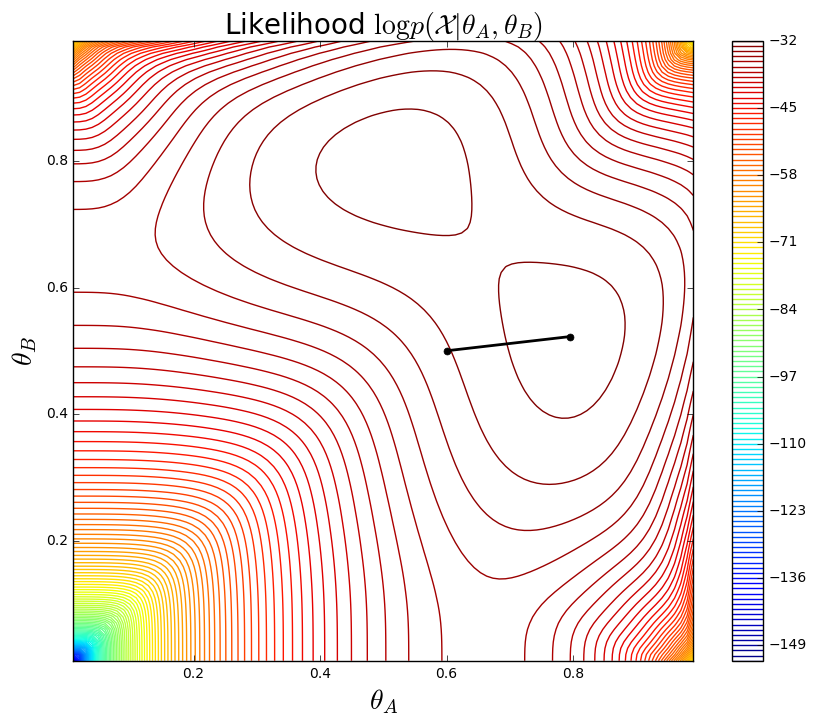

In [4]:
plot_coin_likelihood(rolls, thetas)

### Another example

Let's run it again with different initial biases. Notice it converges to a different local optima.

In [5]:
thetas2, _ = coin_em(rolls, 0.1, 0.3, maxiter=6)


#0:	0.10 0.30
#1:	0.43 0.66
#2:	0.50 0.75
#3:	0.51 0.78
#4:	0.52 0.79
#5:	0.52 0.79


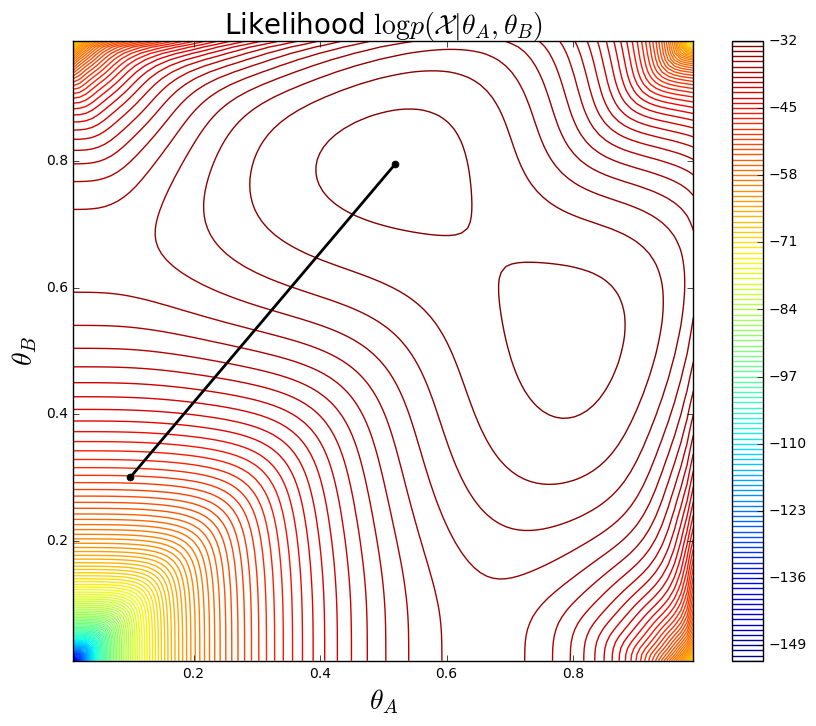

In [6]:
plot_coin_likelihood(rolls, thetas2)

## Theory

$$ \LaTeX \text{ command declarations here.}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

### The model

The corresponding probabilistic model of this coin flip experiment is a **mixture of binomials**:
$$
\begin{align}
\theta &= (\theta_A, \theta_B)  &                       
    &&\text{fixed coin biases} \\
Z_n &\sim \mathrm{Uniform}\{A, B \}    & \forall\, n=1,\dots,N
    &&\text{coin indicators} \\
X_n | Z_n, \theta &\sim \Bin[\theta_{Z_n}, M] & \forall\, n=1,\dots,N
    &&\text{head count}
\end{align}
$$

and the corresponding graphical model is:

<img src="coinflip-graphical-model.png">


The **complete data log-likelihood** for a single trial $(x_n,z_n)$ is
$$
\log p(x_n, z_n | \theta) = \log p(z_n) + \log p(x_n | z_n, \theta)
$$
Here, $P(z_n)=\frac{1}{2}$.  The remaining term is
$$
\begin{align} 
\log p(x_n | z_n, \theta)
&= \log \binom{M}{x_n} \theta_{z_n}^{x_n} (1-\theta_{z_n})^{M-x_n} \\
&= \log \binom{M}{x_n} + x_n \log\theta_{z_n} + (M-x_n)\log(1-\theta_{z_n})
\end{align}
$$


### E-Step

The **E-Step** involves writing down an expression for
$$
\begin{align}
E_q[\log p(\X, Z | \theta )]                  
&= E_q[\log p(\X | Z, \theta) p(Z)] \\
&= E_q[\log p(\X | Z, \theta)] + \log p(Z) \\
\end{align}
$$

The $\log p(Z)$ term is constant wrt $\theta$, so we ignore it.
> Recall $q \equiv q_{\theta_t} = p(Z | \X,\theta_t)$

\begin{align}
E_q[\log p(\X | Z, \theta)]
&= \sum_{n=1}^N E_q \bigg[
        x_n \log \theta_{z_n} + (M-x_n) \log (1-\theta_{z_n}) 
    \bigg] + \text{const.}
\\
&= \sum_{n=1}^N q_\vartheta(z_n=A)
    \bigg[ x_n \log \theta_A + (M-x_n) \log (1-\theta_A) \bigg] \\
&+ \sum_{n=1}^N q_\vartheta(z_n=B)
    \bigg[ x_n \log \theta_B + (M-x_n) \log (1-\theta_B) \bigg]
 + \text{const.}
\end{align}


### M-Step

Let $a_n = q(z_n = A)$ and $b_n = q(z_n = B)$.  Taking derivatives with respect to $\theta_A$ and $\theta_B$, we obtain the following update rules:
$$
\theta_A = \frac{\sum_{n=1}^N a_n x_n}{\sum_{n=1}^N a_n M}
\qquad
\theta_B = \frac{\sum_{n=1}^N b_n x_n}{\sum_{n=1}^N b_n M}
$$

> **Interpretation:** For each coin, examples are *biased* according to the probability that they belong to that coin.  Observing $M$ flips is equivalent to observing $a_n M$ *effective* flips.